## UMAP MNMG runtime on large dataset

In [1]:
from cuml.dask.manifold import UMAP as UMAP_MNMG
from cuml.manifold import UMAP
from cuml.dask.datasets import make_blobs

from dask_cuda import LocalCUDACluster
from dask.distributed import Client, wait

import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_data(args, client):
    dX, _ = make_blobs(n_samples=args['n_samples'],
                       n_features=args['n_features'],
                       cluster_std=1.0,
                       dtype="float32",
                       n_parts=args['n_parts'],
                       client=client)
    n_to_sample = int(args['n_samples'] * args['sampling_ratio'])
    dX = client.persist(dX)
    wait(dX)
    lX = dX[:n_to_sample].compute()
    return lX, dX

In [3]:
def benchmark(args):
    # Start Dask-CUDA cluster & Dask client
    cluster = LocalCUDACluster(n_workers=args['n_parts'], threads_per_worker=1)
    client = Client(cluster)

    lX, dX = generate_data(args, client)
    
    # Measure runtime accross n_iter runs (+1 "warm-up test")
    durations = []
    for i in range(args['n_iter'] + 1):
        
        # Train local model
        local_model = UMAP(n_components=args['n_components'], n_neighbors=args['n_neighbors'],
                       n_epochs=args['n_epochs'])
        local_model.fit(lX)
        
        # Pass trained model and order distributed inference
        model = UMAP_MNMG(local_model)
        lazy_transformed = model.transform(dX)
        
        # Perform distributed inference and measure time
        start = time.time()
        lazy_transformed.compute()
        durations.append(time.time()-start)
    
    # Remove "warm-up" test
    durations = np.array(durations[1:])
    
    # Stop Dask-CUDA cluster & Dask client
    client.close()
    cluster.close()
    
    # Return runtime average
    return durations.mean()

In [4]:
def runtime_barchart(args, mean_durations):
    labels = ['1 GPU', '2 GPUs', '4 GPUs', '8 GPUs']
    runtimes = list(map(lambda x: round(x, 2), mean_durations))
    x = np.arange(len(labels))
    fig, ax = plt.subplots()
    rects = ax.bar(x, runtimes, 0.35)

    ax.set_ylabel('Runtime (s)')
    ax.set_title('Scale of random dataset transform: {}x{}'.format(args['n_samples'], args['n_features']))
    ax.set_xticks(x)
    ax.set_xticklabels(labels)


    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects)
    fig.tight_layout()
    plt.show()

Number of GPUs: 1, mean runtime: 25.30
Number of GPUs: 2, mean runtime: 13.38
Number of GPUs: 4, mean runtime: 7.34
Number of GPUs: 8, mean runtime: 4.50


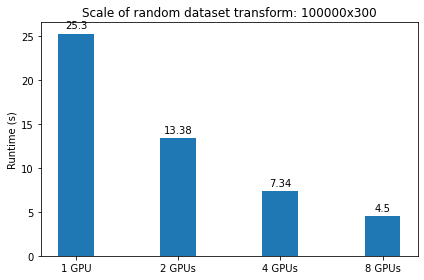

In [5]:
args = {'n_samples': 100000, 'n_features':300,
        'n_components': 64, 'n_neighbors':15, 'n_epochs':5000,
        'sampling_ratio': 0.001, 'n_iter': 3}

mean_runtimes = []
for n_gpus in [1, 2, 4, 8]:
    args['n_parts'] = n_gpus
    mean_runtime = benchmark(args)
    mean_runtimes.append(mean_runtime)
    print("Number of GPUs: {}, mean runtime: {:.2f}".format(n_gpus, mean_runtime))
runtime_barchart(args, mean_runtimes)

In [6]:
import csv

with open('../results/mnmg_scaling.csv','w') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(['number of GPUs', 'transformation runtime (s)'])
    for i, n_gpus in enumerate([1, 2, 4, 8]):
        csv_out.writerow([n_gpus, mean_runtimes[i]])